In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Whirly"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn088511,MSLGPRESCEFFHDPFKGKSEEGKVRKVLKVEPLPDGTGHFFNLSW...,276,1
1,Achn144601,MRERDAWVSLGGGEIESSFEEEDIGEGLGIQNPNRWSIIHSPSSLN...,341,1
2,Achn183721,MLNLFLSSSPPGLTIPNPKPFCVLHSFSSLDAIAAIRLKPTPSSLS...,649,1
3,EMT14910,MGFSIDGPGRGLGFLPRALLGPAYGQSGAYKVAKEGFVLLQFAPAV...,219,1
4,EMT15491,MLRLSRFLPSTSRGVTDLKDVLWSGSLTFKHALSTSAANVDARYML...,352,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
492,0.008197,0.000000,0.000000,0.008197,0.000000,0.000000,0.0000,0.000000,0.0,0.024590,...,0.00000,0.0000,0.0,0.000000,0.000000,0.008197,0.000000,0.0,0.0,0.00000
498,0.009646,0.003215,0.000000,0.006431,0.006431,0.000000,0.0000,0.003215,0.0,0.003215,...,0.00000,0.0000,0.0,0.000000,0.003215,0.000000,0.003215,0.0,0.0,0.00000
360,0.031646,0.003165,0.003165,0.006329,0.003165,0.006329,0.0000,0.000000,0.0,0.022152,...,0.00000,0.0000,0.0,0.000000,0.003165,0.003165,0.000000,0.0,0.0,0.00000
915,0.005900,0.000000,0.000000,0.008850,0.000000,0.000000,0.0059,0.002950,0.0,0.014749,...,0.00295,0.0059,0.0,0.000000,0.002950,0.000000,0.002950,0.0,0.0,0.00295
704,0.006711,0.006711,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.006711,...,0.00000,0.0000,0.0,0.006711,0.000000,0.000000,0.000000,0.0,0.0,0.00000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (833, 437)
X_test: (209, 437)
y_train: (833,)
y_test: (209,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,393 (607.00 KB)

 Trainable params: 155,393 (607.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.5000 - loss: 0.6933

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5822 - loss: 0.6907 - val_accuracy: 0.8743 - val_loss: 0.6694


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.6708

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.6545 - val_accuracy: 0.9701 - val_loss: 0.5747


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.5699

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9567 - loss: 0.5274 - val_accuracy: 0.9820 - val_loss: 0.3298


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.3507

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9737 - loss: 0.2839 - val_accuracy: 0.9820 - val_loss: 0.1012


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1093

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.0897 - val_accuracy: 0.9820 - val_loss: 0.0487


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0394

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0429 - val_accuracy: 0.9880 - val_loss: 0.0472


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0212

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0233 - val_accuracy: 0.9820 - val_loss: 0.0620


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0193

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0179 - val_accuracy: 0.9820 - val_loss: 0.0447


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0066

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0117 - val_accuracy: 0.9880 - val_loss: 0.0606


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0401

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0148 - val_accuracy: 0.9820 - val_loss: 0.0522


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0029

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9820 - val_loss: 0.0524


Epoch 12/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0051

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0106 - val_accuracy: 0.9820 - val_loss: 0.0572


Epoch 13/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0035

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9820 - val_loss: 0.0654


Epoch 14/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7068e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9820 - val_loss: 0.0648


Epoch 15/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9820 - val_loss: 0.0621


Epoch 16/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9820 - val_loss: 0.0711



[Train Accuracy: 100.00% - Test Accuracy: 99.04%]


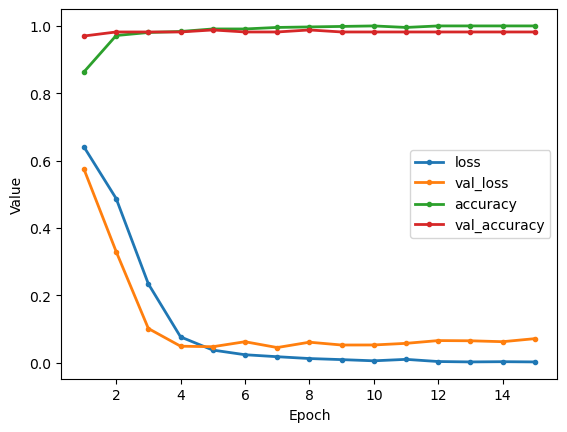

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYX,YYY
492,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.004115,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.000000,0.000000,0.000000,0.003226,0.0,0.000000,0.000000,0.0,0.0,0.003226,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.012698,0.003175,0.003175,0.000000,0.0,0.003175,0.000000,0.0,0.0,0.003175,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002959,0.0,0.0,0.002959,...,0.002959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (833, 8231)
X_test: (209, 8231)
y_train: (833,)
y_test: (209,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,107,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,150,657 (8.20 MB)

 Trainable params: 2,150,657 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.5312 - loss: 0.6931

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5508 - loss: 0.6904  

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5636 - loss: 0.6895 - val_accuracy: 0.9880 - val_loss: 0.6595


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.6600

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9779 - loss: 0.6401 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9779 - loss: 0.6356 - val_accuracy: 0.9940 - val_loss: 0.5160


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.4942

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9947 - loss: 0.4591 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.4512 - val_accuracy: 0.9820 - val_loss: 0.2764


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2759

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.2401 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.2317 - val_accuracy: 0.9820 - val_loss: 0.1024


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0856

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9941 - loss: 0.0713 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9938 - loss: 0.0685 - val_accuracy: 0.9880 - val_loss: 0.0386


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0161

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0196 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0200 - val_accuracy: 0.9701 - val_loss: 0.0703


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0166

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9953 - loss: 0.0075 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9956 - loss: 0.0077 - val_accuracy: 0.9940 - val_loss: 0.0221


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0044

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0054 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9820 - val_loss: 0.0574


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0027

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0046 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0045 - val_accuracy: 0.9880 - val_loss: 0.0343


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 9.3388e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011     

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9880 - val_loss: 0.0414


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.2480e-04

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8414e-04 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9799e-04 - val_accuracy: 0.9820 - val_loss: 0.0554


Epoch 12/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.1192e-04

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0619e-04 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9491e-04 - val_accuracy: 0.9820 - val_loss: 0.0640



[Train Accuracy: 100.00% - Test Accuracy: 98.09%]


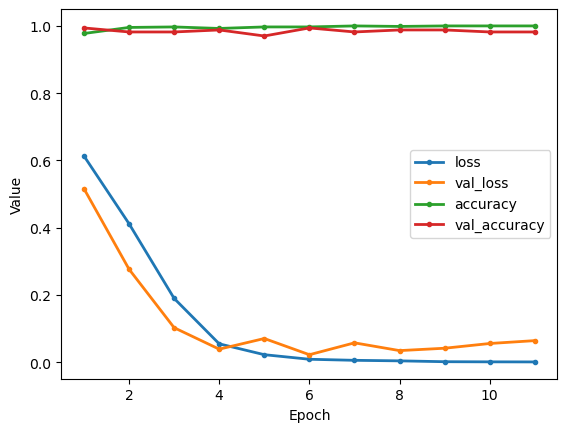

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYG,YYYH,YYYL,YYYN,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
492,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.006369,0.0,0.0,0.0,0.0,0.003185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      23,123,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,164,417 (88.37 MB)

 Trainable params: 23,164,417 (88.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.4844 - loss: 0.6932

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5408 - loss: 0.6930 

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5345 - loss: 0.6930

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5331 - loss: 0.6928

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5317 - loss: 0.6927

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5297 - loss: 0.6925

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5283 - loss: 0.6924

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5276 - loss: 0.6921 - val_accuracy: 0.9760 - val_loss: 0.6818


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9062 - loss: 0.6829

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9280 - loss: 0.6813

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9399 - loss: 0.6796

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9471 - loss: 0.6778

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9527 - loss: 0.6756

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9568 - loss: 0.6734

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9584 - loss: 0.6725 - val_accuracy: 0.9461 - val_loss: 0.6282


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9688 - loss: 0.6179

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9792 - loss: 0.6177

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9827 - loss: 0.6131

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9838 - loss: 0.6081

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9850 - loss: 0.6021

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9858 - loss: 0.5958

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9861 - loss: 0.5932 - val_accuracy: 0.9581 - val_loss: 0.4825


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9844 - loss: 0.4609

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9905 - loss: 0.4456

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9922 - loss: 0.4325

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9927 - loss: 0.4263

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9932 - loss: 0.4145

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9934 - loss: 0.4025

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9933 - loss: 0.3927 - val_accuracy: 0.9521 - val_loss: 0.2478


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.1867

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9957 - loss: 0.1767

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9960 - loss: 0.1679

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9958 - loss: 0.1604

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9955 - loss: 0.1535

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9953 - loss: 0.1471

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9952 - loss: 0.1446 - val_accuracy: 0.9581 - val_loss: 0.1144


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0422

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0390

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9986 - loss: 0.0376

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9983 - loss: 0.0355

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9983 - loss: 0.0340

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9980 - loss: 0.0329

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9979 - loss: 0.0324 - val_accuracy: 0.9581 - val_loss: 0.0795


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0107

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0094

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0094

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0094

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0093

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0091

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9997 - loss: 0.0092

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9996 - loss: 0.0092 - val_accuracy: 0.9641 - val_loss: 0.0745


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0030

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0056

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0056

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0056

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0054

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0052

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9701 - val_loss: 0.0607


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0017

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0019

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0025

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0026

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0025

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0025

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9701 - val_loss: 0.0723


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 6.8818e-04

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 7.9953e-04

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 8.5436e-04

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 8.8176e-04

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 9.5107e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0010    

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9641 - val_loss: 0.0874


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0017

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0012

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0011

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0010

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 9.7658e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 9.4743e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 9.3724e-04 - val_accuracy: 0.9641 - val_loss: 0.0878



[Train Accuracy: 100.00% - Test Accuracy: 97.13%]


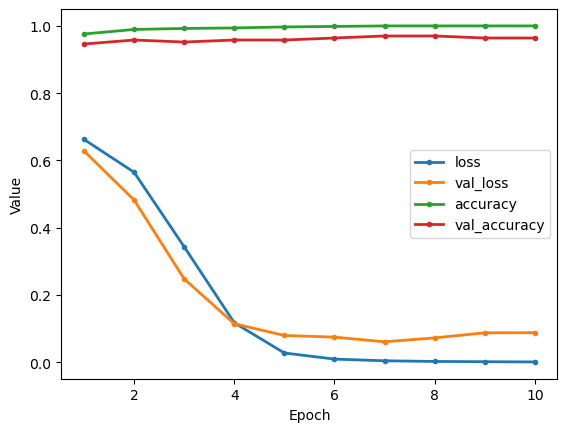

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [25]:
report.save()

Report saved as Output/Reports/Whirly/report_1EQO4LG1.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################